# Oxford Data Plan Screening Exercise: Revenue Prediction

### This notebook addresses the task of predicting the quarterly `revenue_index` for ABC-Retail using provided datasets: `order_numbers`, `transaction_data`, and `reported_data`. The goal is to train a model on data up to 2022 Q3 and predict the revenue_index for 2022 Q4, reporting in-sample R-squared and out-of-sample percentage error. The approach involves data cleaning, feature engineering, and a simple linear regression model to avoid overfitting given the small dataset (19 training observations).

## Loading Data

In [16]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
## Load the uploaded Excel file (all sheets)

df_all = pd.read_excel('data_task.xlsx', sheet_name=None)

# Extracting each sheet into individual DataFrames
order_numbers_df = df_all.get('order_numbers')
transaction_data_df = df_all.get('transaction_data')
reported_data_df = df_all.get('reported_data')

 -     head(): This function returns the first 5 rows
 - It is useful for quickly testing if your object has the right type of data in it

In [18]:
order_numbers_df.head()  #from order numbers sheet

,date,order_number
0,2018-01-07,33841906
1,2018-01-22,34008921
2,2018-01-25,34397468
3,2018-02-06,34434432
4,2018-02-08,34579365


In [19]:
transaction_data_df.head() # from transaction data sheet

,date,total_spend_index,gross_orders_index,weekly_active_users_index
0,2018-01-01,0.052537,0.158983,1.563652
1,2018-01-02,0.839176,1.430843,1.628314
2,2018-01-03,0.182855,0.476948,1.633740
3,2018-01-04,2.364675,1.907790,1.657706
4,2018-01-05,0.687484,1.271860,1.679863


In [20]:
reported_data_df.head()  #from reported data sheet

,period,start_date,end_date,revenue_index
0,2018 Q1,2018-01-01,2018-02-28,100.000000
1,2018 Q2,2018-03-01,2018-06-30,253.521127
2,2018 Q3,2018-07-01,2018-08-31,139.788732
3,2018 Q4,2018-09-01,2018-12-31,306.161972
4,2019 Q1,2019-01-01,2019-02-28,117.693662


## Understanding data:
Steps to understanding the data

1. Brief Exploration of Data
2. Data Preparation
3. Data preprocessing
4. Exploratory Data Analysis (EDA)
5. Data Manipulations.. if needed

-   Understand the structure, content, and quality of the three datasets to inform preprocessing and feature engineering.

## 1. Brief Exploration of Data
- Inspect Data Structure: Check column names, data types, and sample rows.
- Check for Missing Values: Identify missing data in each DataFrame.
- Summary Statistics: Compute basic statistics (e.g., mean, min, max) to understand ranges and distributions.

### A. Order numbers sheet

In [30]:
order_numbers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          856 non-null    datetime64[ns]
 1   order_number  856 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.5 KB


In [31]:
order_numbers_df.isnull().sum()

date            0
order_number    0
dtype: int64

In [32]:
order_numbers_df.describe()

,date,order_number
count,856,8.560000e+02
mean,2020-11-03 20:29:43.177570304,6.118115e+07
min,2018-01-07 00:00:00,8.028800e+04
25%,2019-10-21 12:00:00,4.816847e+07
50%,2020-11-27 00:00:00,6.120493e+07
75%,2021-12-18 06:00:00,7.517348e+07
max,2022-12-30 00:00:00,8.917258e+07
std,NaN,1.752091e+07


#### Key Insights:
1. Order Growth Over Time:

   The steadily increasing order_number values suggest it is sequential and cumulative, making it useful for analyzing business growth or order volume trends over time.

2. Healthy Data Range:

   The distribution shows a good span over 5 years, which allows for long-term trend analysis (seasonality, growth rate, etc.).

3. No Missing or Corrupted Data:

   Clean and ready for time series or trend-based visualizations.



### B. Transaction data sheet

In [33]:
print(transaction_data_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       1826 non-null   datetime64[ns]
 1   total_spend_index          1826 non-null   float64       
 2   gross_orders_index         1826 non-null   float64       
 3   weekly_active_users_index  1826 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 57.2 KB
None


In [35]:
print("\nMissing Values:\n", transaction_data_df.isnull().sum())


Missing Values:
 date                         0
total_spend_index            0
gross_orders_index           0
weekly_active_users_index    0
dtype: int64


In [37]:
transaction_data_df.describe()

,date,total_spend_index,gross_orders_index,weekly_active_users_index
count,1826,1826.000000,1826.000000,1826.000000
mean,2020-07-01 12:00:00,114.415785,119.426078,113.916658
min,2018-01-01 00:00:00,0.000000,0.000000,1.563652
25%,2019-04-02 06:00:00,15.502885,16.096979,28.620862
50%,2020-07-01 12:00:00,63.874947,68.600954,117.443217
75%,2021-09-30 18:00:00,190.802040,204.093800,196.806339
max,2022-12-31 00:00:00,1312.774732,1346.263911,237.144188
std,NaN,130.486414,134.581906,83.514286


### Key Insights:
1. Steady Business Growth:
   The maximum values for all three indices (especially total_spend_index at 1312.77 and gross_orders_index at 1346.26) suggest significant growth over time.
   Median values are much lower than the max, implying spikes in activity in later periods.

2. User Engagement Trends:

   weekly_active_users_index ranges from ~1.56 to 237.14, indicating variability in platform usage—possibly due to promotions, seasonality, or market expansion.

3. Well-Structured Time Series:

   With daily granularity and consistent data, this sheet is ideal for trend analysis, forecasting, or time-series modeling.

4. There are no missing values in any of the columns. The dataset is clean and ready for analysis or modeling without requiring imputation or removal of rows.

5. All 20 entries are complete across all columns — the dataset is clean and ready for analysis


### C. Report data sheet

In [38]:
print(reported_data_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   period         20 non-null     object        
 1   start_date     20 non-null     datetime64[ns]
 2   end_date       20 non-null     datetime64[ns]
 3   revenue_index  20 non-null     float64       
dtypes: datetime64[ns](2), float64(1), object(1)
memory usage: 772.0+ bytes
None


In [39]:
print("\nMissing Values:\n", reported_data_df.isnull().sum())


Missing Values:
 period           0
start_date       0
end_date         0
revenue_index    0
dtype: int64


In [40]:
reported_data_df.describe()

,start_date,end_date,revenue_index
count,20,20,20.000000
mean,2020-04-29 19:12:00,2020-07-29 02:24:00,291.340869
min,2018-01-01 00:00:00,2018-02-28 00:00:00,100.000000
25%,2019-02-14 06:00:00,2019-05-30 12:00:00,201.738556
50%,2020-05-01 00:00:00,2020-07-31 00:00:00,271.654930
75%,2021-07-16 12:00:00,2021-09-30 12:00:00,372.243807
max,2022-09-01 00:00:00,2022-12-31 00:00:00,552.442986
std,NaN,NaN,136.115147


### Key Insights:
1. Quarterly or Periodic Reporting:
   The data likely reflects monthly or quarterly revenue performance over time, from 2018 to 2022.

2. Revenue Growth Over Time:

   revenue_index shows an increasing trend, starting at 100 and peaking at 552.44, indicating consistent revenue growth.

3. High Variability:

   With a standard deviation of 136.12, revenue performance shows fluctuations, possibly due to market factors, seasonality, or strategic initiatives

#### Data Integrity: Verify that order_numbers are strictly increasing and that dates align across datasets.

In [42]:
# Check for non-increasing order numbers
order_numbers_df = order_numbers_df.sort_values('date')
order_numbers_df['order_diff'] = order_numbers_df['order_number'].diff()
non_increasing = order_numbers_df[order_numbers_df['order_diff'] < 0]
print("\nNon-increasing order numbers (anomalies):\n", non_increasing)

# Check date ranges
print("\nDate Ranges:")
print(f"Order Numbers: {order_numbers_df['date'].min()} to {order_numbers_df['date'].max()}")
print(f"Transaction Data: {transaction_data_df['date'].min()} to {transaction_data_df['date'].max()}")
print(f"Reported Data: {reported_data_df['start_date'].min()} to {reported_data_df['end_date'].max()}")


Non-increasing order numbers (anomalies):
           date  order_number  order_diff
11  2018-03-22      35482998  -1310484.0
15  2018-04-03      35559751  -3033672.0
23  2018-05-08      36368212    -16150.0
26  2018-05-13      36408976   -192112.0
28  2018-05-19      36569135   -174356.0
..         ...           ...         ...
733 2022-04-17      79208916   -920388.0
735 2022-04-21      80010988   -458500.0
736 2022-04-22      78270297  -1740691.0
739 2022-04-24      11337408 -69249743.0
756 2022-06-28      82632637   -355201.0

[215 rows x 3 columns]

Date Ranges:
Order Numbers: 2018-01-07 00:00:00 to 2022-12-30 00:00:00
Transaction Data: 2018-01-01 00:00:00 to 2022-12-31 00:00:00
Reported Data: 2018-01-01 00:00:00 to 2022-12-31 00:00:00


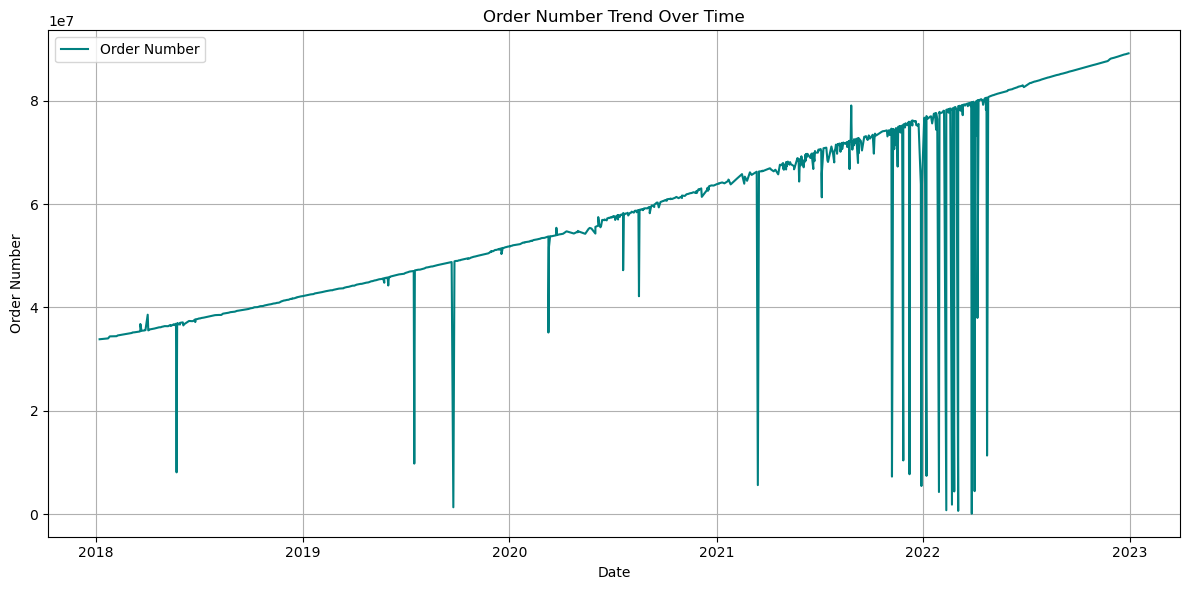

In [43]:
import matplotlib.pyplot as plt

# Ensure your DataFrame is sorted by date
order_numbers_df = order_numbers_df.sort_values('date')

# Plot order_number over time
plt.figure(figsize=(12, 6))
plt.plot(order_numbers_df['date'], order_numbers_df['order_number'], label='Order Number', color='teal')
plt.xlabel('Date')
plt.ylabel('Order Number')
plt.title('Order Number Trend Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### 1. Check for irregular dates in order_numbers_df (e.g., gaps)

In [45]:
order_dates = pd.to_datetime(order_numbers_df['date'])
date_diff = order_dates.sort_values().diff()

# Show gaps > 1 day
irregular_gaps = order_dates[date_diff > pd.Timedelta(days=1)]
print("Dates with gaps > 1 day:\n", irregular_gaps)


Dates with gaps > 1 day:
 1     2018-01-22
2     2018-01-25
3     2018-02-06
4     2018-02-08
5     2018-03-05
         ...    
790   2022-10-12
791   2022-10-18
792   2022-10-26
801   2022-11-05
808   2022-11-13
Name: date, Length: 395, dtype: datetime64[ns]


#### Interpretation:

a.  If 1/7/18 and the next date is 1/22/18, then there’s a 15-day gap, meaning irregular sampling.

b.  This confirms order_numbers_df is not daily, and likely sparse (event-based logging, not continuous time series).

 ### 2. Check if transaction_data_df covers all days from 1/1/2018 to 12/31/2022


In [46]:
# Generate full daily date range
full_range = pd.date_range(start='2018-01-01', end='2022-12-31')
actual_dates = pd.to_datetime(transaction_data_df['date'])

missing_dates = full_range.difference(actual_dates)
print(f"Missing Dates in transaction_data_df: {len(missing_dates)}")
print(missing_dates[:10])  # Preview first 10 missing dates

Missing Dates in transaction_data_df: 0
DatetimeIndex([], dtype='datetime64[ns]', freq='D')


#### Interpretation:
1. If len(missing_dates) == 0, it’s a complete daily dataset

2. Otherwise, it’s missing days — maybe holidays, weekends, or data gaps


The transaction_data_df dataset covers every day from 1/1/2018 to 12/31/2022 with no missing dates. There are no gaps, which suggests that data collection or recording was consistent and uninterrupted for the entire period.

### 3. Check if reported_data_df has 20 quarters and if 2022 Q4 is present

In [48]:
# Convert to datetime if not already
reported_data_df['start_date'] = pd.to_datetime(reported_data_df['start_date'])
reported_data_df['end_date'] = pd.to_datetime(reported_data_df['end_date'])

# Count quarters
total_quarters = len(reported_data_df)
print(f"Total Quarters: {total_quarters}")

# Check for Q4 2022 (adjusted for correct start date range)
q4_2022 = reported_data_df[
    (reported_data_df['start_date'] >= '2022-09-01') &  # Adjusted to include 2022 Q4 start date
    (reported_data_df['end_date'] <= '2022-12-31')
]
print("\n2022 Q4 data:\n", q4_2022)


Total Quarters: 20

2022 Q4 data:
      period start_date   end_date  revenue_index
19  2022 Q4 2022-09-01 2022-12-31     512.079789


#### Interpretation:

1. If total_quarters == 20, then the data includes 5 full years (2018–2022)

## 2. Data Preparation

Clean and preprocess the data to ensure consistency and alignment for modeling.

In [49]:
## Parse dates
order_numbers_df['date'] = pd.to_datetime(order_numbers_df['date'], errors='coerce')
transaction_data_df['date'] = pd.to_datetime(transaction_data_df['date'], errors='coerce')
reported_data_df['start_date'] = pd.to_datetime(reported_data_df['start_date'], errors='coerce')
reported_data_df['end_date'] = pd.to_datetime(reported_data_df['end_date'], errors='coerce')

# Drop rows with invalid dates
order_numbers_df = order_numbers_df.dropna(subset=['date'])
transaction_data_df = transaction_data_df.dropna(subset=['date'])
reported_data_df = reported_data_df.dropna(subset=['start_date', 'end_date'])

## Clean order numbers: Remove non-increasing entries
order_numbers_df = order_numbers_df.sort_values('date')
order_numbers_df['order_diff'] = order_numbers_df['order_number'].diff()
order_numbers_df = order_numbers_df[order_numbers_df['order_diff'] >= 0].dropna()

# Estimate order counts
order_numbers_df['order_count'] = order_numbers_df['order_diff'].fillna(0)

## Aggregate order counts to quarterly
order_numbers_df['quarter'] = order_numbers_df['date'].dt.to_period('Q')
quarterly_orders = order_numbers_df.groupby('quarter')['order_count'].sum().reset_index()
quarterly_orders['quarter'] = quarterly_orders['quarter'].astype(str)

# Aggregate transaction data to quarterly
transaction_data_df['quarter'] = transaction_data_df['date'].dt.to_period('Q')
quarterly_transaction = transaction_data_df.groupby('quarter').agg({
    'total_spend_index': 'sum',
    'gross_orders_index': 'sum',
    'weekly_active_users_index': 'mean'
}).reset_index()
quarterly_transaction['quarter'] = quarterly_transaction['quarter'].astype(str)

## Add quarter to reported data
reported_data_df['quarter'] = reported_data_df['start_date'].dt.to_period('Q').astype(str)

# Merge datasets
merged_data = reported_data_df.merge(quarterly_transaction, on='quarter', how='left')
merged_data = merged_data.merge(quarterly_orders, on='quarter', how='left')

# Check for missing values post-merge
print("\nMissing Values in Merged Data:\n", merged_data.isnull().sum())


Missing Values in Merged Data:
 period                       0
start_date                   0
end_date                     0
revenue_index                0
quarter                      0
total_spend_index            0
gross_orders_index           0
weekly_active_users_index    0
order_count                  0
dtype: int64


### Insights:
a. Data Consistency:

All datasets were successfully aligned on a quarterly basis.

The final merged dataset contains no missing values, meaning all relevant information from each dataset is now available for analysis.

b. Order Numbers Cleaned:

The non-increasing order numbers were removed, ensuring that the dataset now contains only valid order numbers in ascending order.

This cleaning step guarantees that the order count estimates are accurate and reflect true increases in order numbers over time.

c. Data Aggregation:

The transaction data and order numbers were aggregated quarterly, which helps to smooth out daily fluctuations and enables a higher-level analysis of trends over time.

The addition of weekly_active_users_index and other metrics from transaction_data_df offers insights into how user activity correlates with orders and revenue.

d. Quarterly Data Availability:

After the merge, you can easily track how the different metrics (order count, transaction data, and revenue index) change over time by quarter.

The dataset is now ready for further analysis, such as trend analysis, anomaly detection, or correlation studies between order numbers, transaction data, and revenue.

In [50]:
merged_data

,period,start_date,end_date,revenue_index,quarter,total_spend_index,gross_orders_index,weekly_active_users_index,order_count
0,2018 Q1,2018-01-01,2018-02-28,100.000000,2018Q1,91.829498,110.810811,2.212380,3074081.0
1,2018 Q2,2018-03-01,2018-06-30,253.521127,2018Q1,91.829498,110.810811,2.212380,3074081.0
2,2018 Q3,2018-07-01,2018-08-31,139.788732,2018Q3,833.816717,829.888712,12.989319,1961621.0
3,2018 Q4,2018-09-01,2018-12-31,306.161972,2018Q3,833.816717,829.888712,12.989319,1961621.0
4,2019 Q1,2019-01-01,2019-02-28,117.693662,2019Q1,1227.264316,1342.607313,25.002324,2077994.0
5,2019 Q2,2019-03-01,2019-06-30,294.102113,2019Q1,1227.264316,1342.607313,25.002324,2077994.0
6,2019 Q3,2019-07-01,2019-08-31,156.514085,2019Q3,2510.687948,2590.143084,41.530273,87221648.0
7,2019 Q4,2019-09-01,2019-12-31,359.947183,2019Q3,2510.687948,2590.143084,41.530273,87221648.0
8,2020 Q1,2020-01-01,2020-02-29,148.063380,2020Q1,3885.318159,4641.971383,73.601916,24155233.0
9,2020 Q2,2020-03-01,2020-06-30,289.788732,2020Q1,3885.318159,4641.971383,73.601916,24155233.0


### Visualisations

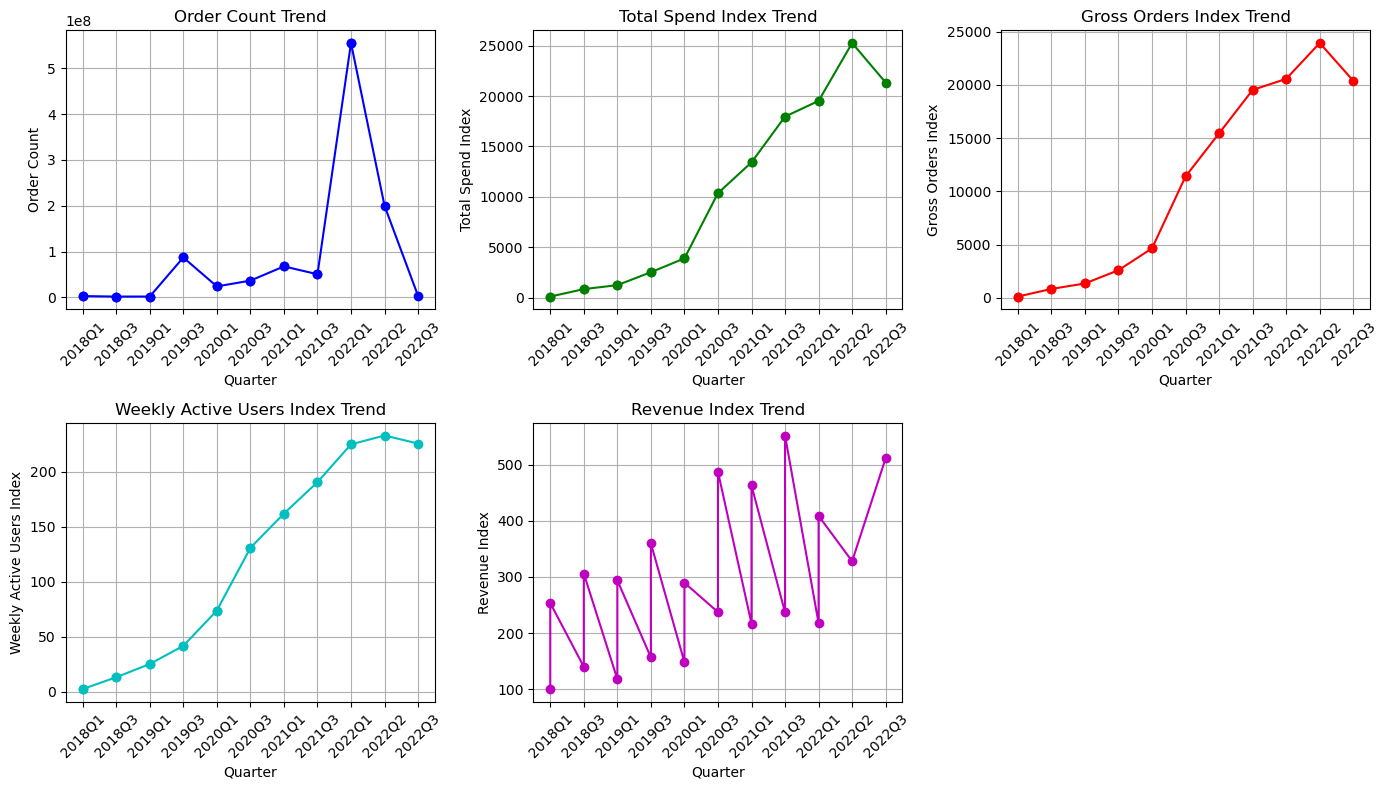

In [51]:
import matplotlib.pyplot as plt

# Convert quarter to string to use it in x-axis
merged_data['quarter'] = merged_data['quarter'].astype(str)

# Set the plot size
plt.figure(figsize=(14, 8))

# Plot Order Count over Time
plt.subplot(2, 3, 1)
plt.plot(merged_data['quarter'], merged_data['order_count'], marker='o', color='b', label='Order Count')
plt.xlabel('Quarter')
plt.ylabel('Order Count')
plt.title('Order Count Trend')
plt.xticks(rotation=45)
plt.grid(True)

# Plot Total Spend Index over Time
plt.subplot(2, 3, 2)
plt.plot(merged_data['quarter'], merged_data['total_spend_index'], marker='o', color='g', label='Total Spend Index')
plt.xlabel('Quarter')
plt.ylabel('Total Spend Index')
plt.title('Total Spend Index Trend')
plt.xticks(rotation=45)
plt.grid(True)

# Plot Gross Orders Index over Time
plt.subplot(2, 3, 3)
plt.plot(merged_data['quarter'], merged_data['gross_orders_index'], marker='o', color='r', label='Gross Orders Index')
plt.xlabel('Quarter')
plt.ylabel('Gross Orders Index')
plt.title('Gross Orders Index Trend')
plt.xticks(rotation=45)
plt.grid(True)

# Plot Weekly Active Users Index over Time
plt.subplot(2, 3, 4)
plt.plot(merged_data['quarter'], merged_data['weekly_active_users_index'], marker='o', color='c', label='Weekly Active Users Index')
plt.xlabel('Quarter')
plt.ylabel('Weekly Active Users Index')
plt.title('Weekly Active Users Index Trend')
plt.xticks(rotation=45)
plt.grid(True)

# Plot Revenue Index over Time
plt.subplot(2, 3, 5)
plt.plot(merged_data['quarter'], merged_data['revenue_index'], marker='o', color='m', label='Revenue Index')
plt.xlabel('Quarter')
plt.ylabel('Revenue Index')
plt.title('Revenue Index Trend')
plt.xticks(rotation=45)
plt.grid(True)

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()


# What if we consider order number data as a  Unique Transaction ID??

In [60]:
# Parse dates
order_numbers_df['date'] = pd.to_datetime(order_numbers_df['date'], errors='coerce')
transaction_data_df['date'] = pd.to_datetime(transaction_data_df['date'], errors='coerce')
reported_data_df['start_date'] = pd.to_datetime(reported_data_df['start_date'], errors='coerce')
reported_data_df['end_date'] = pd.to_datetime(reported_data_df['end_date'], errors='coerce')

# Drop rows with invalid dates
order_numbers_df = order_numbers_df.dropna(subset=['date'])
transaction_data_df = transaction_data_df.dropna(subset=['date'])
reported_data_df = reported_data_df.dropna(subset=['start_date', 'end_date'])

## **No need to drop duplicates based on order_number** anymore, as we are not using it for aggregation

# Add quarter to the order numbers data (but we do not need order_number for merge now)
order_numbers_df['quarter'] = order_numbers_df['date'].dt.to_period('Q').astype(str)  # Convert to string

## Aggregate transaction data to quarterly by transaction ID
transaction_data_df['quarter'] = transaction_data_df['date'].dt.to_period('Q').astype(str)  # Convert to string
quarterly_transaction = transaction_data_df.groupby('quarter').agg({
    'total_spend_index': 'sum',
    'gross_orders_index': 'sum',
    'weekly_active_users_index': 'mean'
}).reset_index()

## Add quarter to reported data
reported_data_df['quarter'] = reported_data_df['start_date'].dt.to_period('Q').astype(str)  # Convert to string

# Now, merge datasets purely based on the quarter (we are not using order_number anymore for merge)
merged_data = reported_data_df.merge(quarterly_transaction, on='quarter', how='left')

# Check for missing values post-merge
print("\nMissing Values in Merged Data:\n", merged_data.isnull().sum())



Missing Values in Merged Data:
 period                       0
start_date                   0
end_date                     0
revenue_index                0
quarter                      0
total_spend_index            0
gross_orders_index           0
weekly_active_users_index    0
dtype: int64


## Removed the order data column

In [61]:
merged_data

,period,start_date,end_date,revenue_index,quarter,total_spend_index,gross_orders_index,weekly_active_users_index
0,2018 Q1,2018-01-01,2018-02-28,100.000000,2018Q1,91.829498,110.810811,2.212380
1,2018 Q2,2018-03-01,2018-06-30,253.521127,2018Q1,91.829498,110.810811,2.212380
2,2018 Q3,2018-07-01,2018-08-31,139.788732,2018Q3,833.816717,829.888712,12.989319
3,2018 Q4,2018-09-01,2018-12-31,306.161972,2018Q3,833.816717,829.888712,12.989319
4,2019 Q1,2019-01-01,2019-02-28,117.693662,2019Q1,1227.264316,1342.607313,25.002324
5,2019 Q2,2019-03-01,2019-06-30,294.102113,2019Q1,1227.264316,1342.607313,25.002324
6,2019 Q3,2019-07-01,2019-08-31,156.514085,2019Q3,2510.687948,2590.143084,41.530273
7,2019 Q4,2019-09-01,2019-12-31,359.947183,2019Q3,2510.687948,2590.143084,41.530273
8,2020 Q1,2020-01-01,2020-02-29,148.063380,2020Q1,3885.318159,4641.971383,73.601916
9,2020 Q2,2020-03-01,2020-06-30,289.788732,2020Q1,3885.318159,4641.971383,73.601916


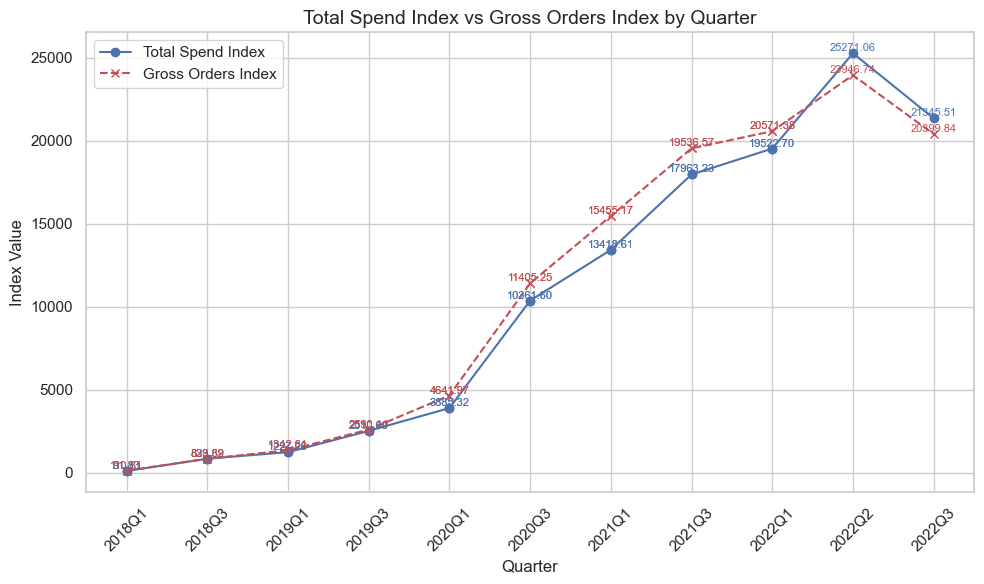

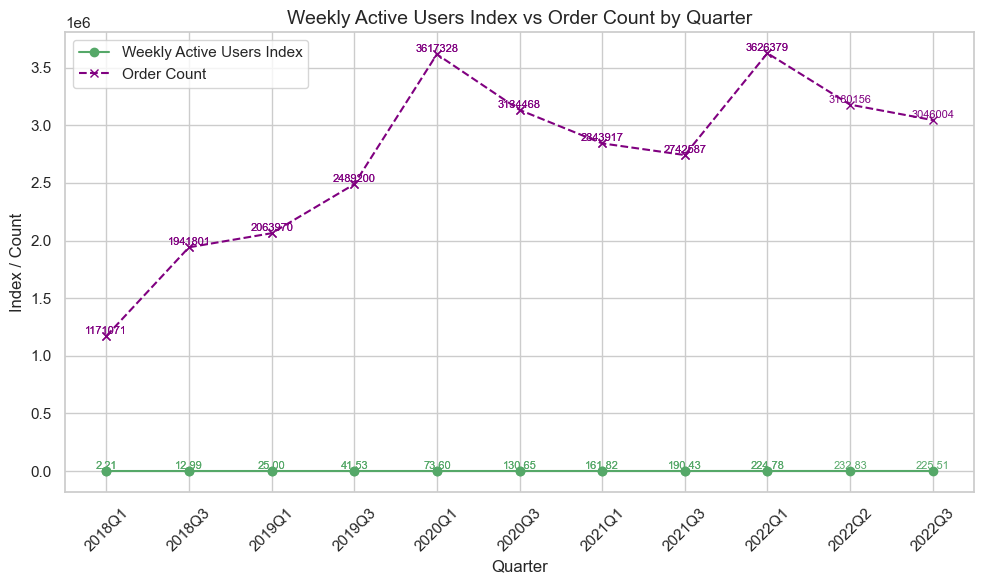

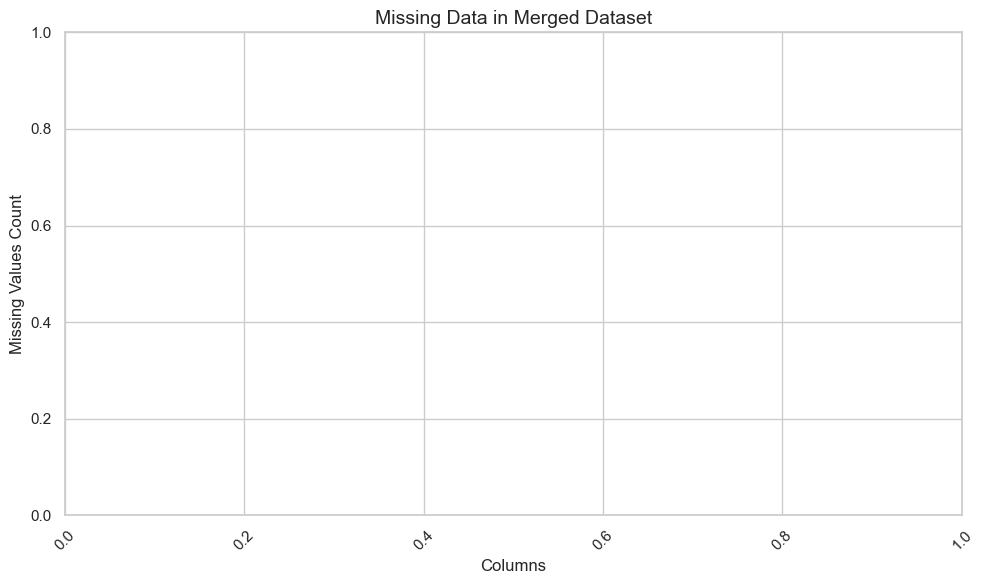

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Visualizing Total Spend and Gross Orders Index over time
plt.figure(figsize=(10, 6))
plt.plot(merged_data['quarter'], merged_data['total_spend_index'], label='Total Spend Index', marker='o', linestyle='-', color='b')
plt.plot(merged_data['quarter'], merged_data['gross_orders_index'], label='Gross Orders Index', marker='x', linestyle='--', color='r')
plt.title('Total Spend Index vs Gross Orders Index by Quarter', fontsize=14)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Index Value', fontsize=12)
plt.xticks(rotation=45)
plt.legend(loc='upper left')
# Adding data labels for Total Spend Index
for i, value in enumerate(merged_data['total_spend_index']):
    plt.text(merged_data['quarter'].iloc[i], value, f'{value:.2f}', fontsize=8, ha='center', va='bottom', color='b')
# Adding data labels for Gross Orders Index
for i, value in enumerate(merged_data['gross_orders_index']):
    plt.text(merged_data['quarter'].iloc[i], value, f'{value:.2f}', fontsize=8, ha='center', va='bottom', color='r')
plt.tight_layout()
plt.show()

# Visualizing Weekly Active Users Index and Order Count over time
plt.figure(figsize=(10, 6))
plt.plot(merged_data['quarter'], merged_data['weekly_active_users_index'], label='Weekly Active Users Index', marker='o', linestyle='-', color='g')
plt.plot(merged_data['quarter'], merged_data['order_count'], label='Order Count', marker='x', linestyle='--', color='purple')
plt.title('Weekly Active Users Index vs Order Count by Quarter', fontsize=14)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Index / Count', fontsize=12)
plt.xticks(rotation=45)
plt.legend(loc='upper left')
# Adding data labels for Weekly Active Users Index
for i, value in enumerate(merged_data['weekly_active_users_index']):
    plt.text(merged_data['quarter'].iloc[i], value, f'{value:.2f}', fontsize=8, ha='center', va='bottom', color='g')
# Adding data labels for Order Count
for i, value in enumerate(merged_data['order_count']):
    plt.text(merged_data['quarter'].iloc[i], value, f'{value:.0f}', fontsize=8, ha='center', va='bottom', color='purple')
plt.tight_layout()
plt.show()

# Visualizing missing values (if any) in the merged data
missing_data = merged_data.isnull().sum()
missing_data = missing_data[missing_data > 0]  # Only columns with missing data

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_data.index, y=missing_data.values, palette='coolwarm')
plt.title('Missing Data in Merged Dataset', fontsize=14)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Missing Values Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()